# Active Inference for collaborative pHRI scenarios
This demo notebook provides a full walk-through of how to build a POMDP agent's generative model and perform active inference routine (inversion of the generative model) using the `Agent()` class of `pymdp`. We build a generative model from 'ground up', directly encoding our own A, B, and C matrices.

### Imports

First, import `pymdp` and the modules we'll need.

In [199]:
import os
import sys
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

from pymdp.agent import Agent
from pymdp import utils
from pymdp.maths import softmax

## The world (as represented by the agent's generative model)

### Hidden states

We assume the agent's "represents" (this should make you think: generative _model_ , not _process_ ) its environment using two latent variables that are statistically independent of one another - we can thus represent them using two _hidden state factors._

We refer to these two hidden state factors are `GOAL_STATE` and `CHOICE_STATE`. 

#### 1. `GAME_STATE`
The first factor is a binary variable representing the goal state '(`GOAL_STATE = 0`, a state/level we will call `GOAL_IS_G1`), another (`GOAL_STATE = 1`, a state/level we will call `GOAL_IS_G2`).  Crucially, the agent doesn't _know_ what the `GOAL_STATE` actually is. They will have to infer it by actively furnishing themselves with observations.

#### 2. `CHOICE_STATE`

The second factor is 5-valued variable representing the "No motion", "small motion towards gaol 1", "small motion towards gaol at 2", "go to goal 1" and "go to goal 2" decision-state of the agent. The first state/level of this hidden state factor is do not move state of the agent (`CHOICE_STATE = 0`, a state that we can call `NO_MOTION`); the second state/level is the state the agent occupies when "small motion towards gaol 1"" (`CHOICE_STATE = 1`, a state that we can call `SMALL_MOTION_T0_G1`); the third state/level of this factor is a "small motion towards gaol 2" (`CHOICE_STATE = 2`, a state that we can call `SMALL_MOTION_T0_G2`); the fourth and fifth state/level of this factor is a "go to gaol 1" and "go to goal 2" (`CHOICE_STATE = 3`, a state that we can call `GO_TO_G1`; `CHOICE_STATE = 4`, a state that we can call `GO_TO_G2`). 


#### 3. `HUMAN_STATE`
This state is affecting both the observation and the transition probabilities. In this version I will call them `PROACTIVE_STATE` and `NOT_PROACTIVE_STATE`. The rationale behind the use of these states is that the way the human interacts with the robot will change depending on the level of proactivity. Effectively, having a probabilistic measure of such factor could allow to account for role switching during the interaction. One way would be to use the probability measure as a inihibiting signal that can suppress the reflex arcs/actions of the robot, meaning that it will stay in a `NO_MOTION` state. Another is to embed an observation model that, when the user is in `PROACTIVE_STATE`, will expect that forces towards goals are generated without robot motions inducing them, meaning in the `NO_MOTION` state. Thus we can expect that the robot will prefer to stay in `NO_MOTION` when the human is in `PROACTIVE_STATE`.

In [200]:
factor_names = ["GOAL_STATE", "CHOICE_STATE", "HUMAN_STATE"]
num_factors = len(factor_names) # this is the total number of hidden state factors

GOAL_IS_G1, GOAL_IS_G2 = 0, 1 # let's assign the indices names so that when we build the A matrices, things will be more 'semantically' obvious
NO_MOTION, SMALL_MOTION_TO_G1, SMALL_MOTION_TO_G2, GO_TO_G1, GO_TO_G2 = 0, 1, 2, 3, 4 # let's assign the indices names so that when we build the A matrices, things will be more 'semantically' obvious
NOT_PROACTIVE_STATE, PROACTIVE_STATE = 0, 1 
num_states = [len([GOAL_IS_G1,GOAL_IS_G2]), len([NO_MOTION, SMALL_MOTION_TO_G1, SMALL_MOTION_TO_G2, GO_TO_G1, GO_TO_G2]), len([NOT_PROACTIVE_STATE, PROACTIVE_STATE])] # this is a list of the dimensionalities of each hidden state factor 

### Observations 

The observation modalities themselves are divided into 3 modalities. You can think of these as 3 independent sources of information that the agent has access to. You could think of thus in direct perceptual terms - e.g. 3 different sensory organs like eyes, ears, & nose, that give you qualitatively-different kinds of information. Or you can think of it more abstractly - like getting your news from 3 different media sources (online news articles, Twitter feed, and Instagram).

#### 1. Observations of the force - `FORCE_OBS`
The first observation modality is the `FORCE_OBS` modality, and corresponds to  observations that are functions of the the `GOAL_STATE`. There are three possible outcomes within this modality: `AROUND_ZERO_FORCE` (`FORCE_OBS = 0`), `TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE` (`FORCE_OBS = 1`) and `TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE` (`FORCE_OBS = 2`).

#### 2. "Proprioceptive" or self-state observations - `ACTION_SELF_OBS`
The third observation modality is the `ACTION_SELF_OBS` modality, and corresponds to the agent observing what level of the `CHOICE_STATE` state it is currently in. These observations are direct, 'unambiguous' mappings to the true `CHOICE_STATE` state, and simply allow the agent to "know" whether it's moving left, right or staying still. The levels of this outcome are simply thus `NO_MOTION_O`, `SMALL_MOTION_TO_G1_0`, `SMALL_MOTION_TO_G2_O`, `GO_TO_G1_0` and `GO_TO_G2_0`, where the `_O` suffix simply distinguishes them from their corresponding hidden states, for which they provide direct evidence. 

#### Note about the arbitrariness of 'labelling' observations, before defining the `A` and `C` matrices.

There is a bit of a circularity here, in that that we're "pre-empting" what the A matrix (likelihood mapping) should look like, by giving these observations labels that imply particular roles or meanings. An observation per se doesn't mean _anything_, it's just some discrete index that distinguishes is from another observation. It's only through its probabilistic relationship to hidden states (encoded in the `A` matrix, as we'll see below) that we endow an observation with meaning. 

In [201]:
modality_names = ["FORCE_OBS", "ACTION_SELF_OBS"]
num_modalities = len(modality_names)

AROUND_ZERO_FORCE_EVIDENCE, TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, RIGHT_EVIDENCE, WRONG_EVIDENCE= 0, 1, 2, 3, 4

NO_MOTION_O, SMALL_MOTION_TO_G1_0, SMALL_MOTION_TO_G2_0, GO_TO_G1_0, GO_TO_G2_0 = 0, 1, 2, 3, 4

num_obs = [len([AROUND_ZERO_FORCE_EVIDENCE, TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, RIGHT_EVIDENCE, WRONG_EVIDENCE]), len([NO_MOTION_O, SMALL_MOTION_TO_G1_0, SMALL_MOTION_TO_G2_0, GO_TO_G1_0, GO_TO_G2_0])]

Setting up observation likelihood matrix - first main component of generative model

In [202]:
A = utils.obj_array_zeros([[o] + num_states for _, o in enumerate(num_obs)])

Set up the **first** modality's likelihood mapping, correspond to how `"FORCE_OBS"` i.e. `modality_names[0]` are related to hidden states. The likelihood $$p(o_t|s_t) = o_t A s_t$$ where $o_t$ is a vector with all zeros and a 1 in the index of the observation of interest. In our case the obsercation vector "meaning":
$$
o_t =\\
 [\text{AROUND ZERO FORCE EVIDENCE}, \\
       \text{TOWARDS GAOL 1 HIGH FORCE EVIDENCE},\\
       \text{TOWARDS GAOL 2 HIGH FORCE EVIDENCE}, \\
       \text{RIGHT EVIDENCE} \\
       \text{WRONG EVIDENCE}]

$$

The state vector "meaning":

$$
s_t =\\
 [\text{GOAL IS G1}, \\
       \text{GOAL IS G2}]
$$

In our case, the matrix `A` encodes the expected observation given a state:

$$
A^{no-motion}_{external-force} = 
\begin{bmatrix}
1.0 & 1.0 \\
0.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 0.0
\end{bmatrix}
$$


$$
A^{small-motion-to-G1}_{external-force} = 
\begin{bmatrix}
1.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 1.0 \\
0.0 & 0.0 \\
0.0 & 0.0
\end{bmatrix}
$$

$$
A^{small-motion-to-G2}_{external-force} = 
\begin{bmatrix}
0.0 & 1.0 \\
1.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 0.0
\end{bmatrix}
$$

$$
A^{go-to-G1}_{external-force} = 
\begin{bmatrix}
0.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 0.0 \\
1.0 & 0.0 \\
0.0 & 1.0
\end{bmatrix}
$$

$$
A^{go-to-G2}_{external-force} = 
\begin{bmatrix}
0.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 0.0 \\
0.0 & 1.0 \\
1.0 & 0.0 \\
\end{bmatrix}
$$

In [203]:
# Note 1 : if we want to embed the idea that "sometimes if you are not moving and the goal is at the left you will not receive zero force" we can play
#          with the probabilities A[0][AROUND_ZERO_FORCE_EVIDENCE, 0,  NO_MOTION]  and A[0][AROUND_ZERO_FORCE_EVIDENCE, 1,  NO_MOTION]  (one per column, i.e. on per goal location).
# Note 2: if someone is hesitant she will have lower probability of signaling her intention through force when the robot is not moving but might react properly if the robot moves.
#         This could be taken into account by taking high probability for the row A[0][AROUND_ZERO_FORCE_EVIDENCE,:,  NO_MOTION] for hesitant people and low for determined people.
# Note 3: an alternative way to account for different human behaviors is to consider them as states. For example we could have hesitant_interaction/determined_interaction 
#         states and do inference also on them.
p = 0.9
q = (1 - p)/2

if (p + q) != 1:
    ValueError("The columns of A must sum to 1")
A[0][AROUND_ZERO_FORCE_EVIDENCE,:,  NO_MOTION, NOT_PROACTIVE_STATE] = p # they always get the 'around zero force' observation in the NO_MOTION state
A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE,:,  NO_MOTION, NOT_PROACTIVE_STATE] = q 
A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE,:,  NO_MOTION, NOT_PROACTIVE_STATE] = q 

# Explantion of the first row (similar for the others):
#    the agent expects to see the NEGATIVE_HIGH_FORCE_EVIDENCE observation with 10% probability, if the GOAL_STATE is GOAL_IS_G1, and the agent is in the MOVE_LEFT state
A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G1, NOT_PROACTIVE_STATE] = p
A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G1, NOT_PROACTIVE_STATE] = q

A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G1, NOT_PROACTIVE_STATE] = q
A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G1, NOT_PROACTIVE_STATE] = q

A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G1, NOT_PROACTIVE_STATE] = q
A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G1, NOT_PROACTIVE_STATE] = p

A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G2, NOT_PROACTIVE_STATE] = q
A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G2, NOT_PROACTIVE_STATE] = p

A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G2, NOT_PROACTIVE_STATE] = p
A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G2, NOT_PROACTIVE_STATE] = q

A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G2, NOT_PROACTIVE_STATE] = q
A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G2, NOT_PROACTIVE_STATE] = q

A[0][RIGHT_EVIDENCE,GOAL_IS_G1, GO_TO_G1, NOT_PROACTIVE_STATE] = 1.0
A[0][WRONG_EVIDENCE,GOAL_IS_G2, GO_TO_G1, NOT_PROACTIVE_STATE] = 1.0

A[0][RIGHT_EVIDENCE,GOAL_IS_G2, GO_TO_G2, NOT_PROACTIVE_STATE] = 1.0
A[0][WRONG_EVIDENCE,GOAL_IS_G1, GO_TO_G2, NOT_PROACTIVE_STATE] = 1.0


if (p + q) != 1:
    ValueError("The columns of A must sum to 1")
A[0][AROUND_ZERO_FORCE_EVIDENCE,:,  NO_MOTION, PROACTIVE_STATE] = q # they always get the 'around zero force' observation in the NO_MOTION state
A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE,GOAL_IS_G1,  NO_MOTION, PROACTIVE_STATE] = p
A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE,GOAL_IS_G2,  NO_MOTION, PROACTIVE_STATE] = q 
A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE,GOAL_IS_G1,  NO_MOTION, PROACTIVE_STATE] = q 
A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE,GOAL_IS_G2,  NO_MOTION, PROACTIVE_STATE] = p 

A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G1, PROACTIVE_STATE] = q
A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G1, PROACTIVE_STATE] = q

A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G1, PROACTIVE_STATE] = p
A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G1, PROACTIVE_STATE] = q

A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G1, PROACTIVE_STATE] = q
A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G1, PROACTIVE_STATE] = p


A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G2, PROACTIVE_STATE] = q
A[0][AROUND_ZERO_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G2, PROACTIVE_STATE] = q

A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G2, PROACTIVE_STATE] = p
A[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G2, PROACTIVE_STATE] = q

A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G1, SMALL_MOTION_TO_G2, PROACTIVE_STATE] = q
A[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE, GOAL_IS_G2, SMALL_MOTION_TO_G2, PROACTIVE_STATE] = p

A[0][RIGHT_EVIDENCE,GOAL_IS_G1, GO_TO_G1, PROACTIVE_STATE] = 1.0
A[0][WRONG_EVIDENCE,GOAL_IS_G2, GO_TO_G1, PROACTIVE_STATE] = 1.0

A[0][RIGHT_EVIDENCE,GOAL_IS_G2, GO_TO_G2, PROACTIVE_STATE] = 1.0
A[0][WRONG_EVIDENCE,GOAL_IS_G1, GO_TO_G2, PROACTIVE_STATE] = 1.0



Set up the **second** modality's likelihood mapping, correspond to how `"ACTION_SELF_OBS"` i.e. `modality_names[2]` are related to hidden states.

In [204]:
A[1][NO_MOTION_O,:,NO_MOTION] = 1.0
A[1][SMALL_MOTION_TO_G1_0,:,SMALL_MOTION_TO_G1] = 1.0
A[1][SMALL_MOTION_TO_G2_0,:,SMALL_MOTION_TO_G2] = 1.0
A[1][GO_TO_G1_0,:,GO_TO_G1] = 1.0
A[1][GO_TO_G2_0,:,GO_TO_G2_0] = 1.0
# quick way to do this
# modality_idx, factor_idx = 2, 2
# for sampling_state_i in num_states[factor_idx]:
#     A[modality_idx][sampling_state_i,:,sampling_state_i] = 1.0

### Control state factors

The 'control state' factors are the agent's representation of the control states (or actions) that _it believes_ can influence the dynamics of the hidden states - i.e. hidden state factors that are under the influence of control states are are 'controllable'. In practice, we often encode _every_ hidden state factor as being under the influence of control states, but the 'uncontrollable' hidden state factors are driven by a trivially-1-dimensional control state or action-affordance. This trivial action simply 'maintains the default environmental dynamics as they are' i.e. does nothing. This will become more clear when we set up the transition model (the `B` matrices) below.

#### 1. `NULL`
This reflects the agent's lack of ability to influence the `GOAL_STATE` using policies or actions. The dimensionality of this control factor is 1, and there is only one action along this control factor: `NULL_ACTION` or "don't do anything to do the environment". This just means that the transition dynamics along the `GOAL_STATE` hidden state factor have their own, uncontrollable dynamics that are not conditioned on this `NULL` control state - or rather, _always_ conditioned on an unchanging, 1-dimensional `NULL_ACTION`.

#### 1. `CHOICE_STATE_CONTROL`
This is a control factor that reflects the agent's ability to move itself between the `NO_MOTION`, `SMALL_MOTION_TO_G1`, `SMALL_MOTION_TO_G2`, `GO_TO_G1` and `GO_TO_G2` states of the `CHOICE_STATE` hidden state factor. The levels/values of this control factor are `NO_MOTION_ACTION`, `SMALL_MOTION_TO_G1_ACTION`, `SMALL_MOTION_TO_G2_ACTION`, `GO_TO_G1_ACTION` and `GO_TO_G2_ACTION`. When we describe the `B` matrices below, we will set up the transition dynamics of the `CHOICE_STATE` hidden state factor, such that they are totally determined by the value of the `CHOICE_STATE_CONTROL` factor. 

In [205]:
control_names = ["NULL_STATE_CONTROL", "CHOICE_STATE_CONTROL", "NULL_STATE_CONTROL_HUMAN"]
num_control_factors = len(control_names) # this is the total number of controllable hidden state factors

NULL_ACTION = 0
NO_MOTION_ACTION, SMALL_MOTION_TO_G1_ACTION, SMALL_MOTION_TO_G2_ACTION, GO_TO_G1_ACTION, GO_TO_G2_ACTION = 0, 1, 2, 3, 4

num_control = [len([NULL_ACTION]), len([NO_MOTION_ACTION, SMALL_MOTION_TO_G1_ACTION, SMALL_MOTION_TO_G2_ACTION, GO_TO_G1_ACTION, GO_TO_G2_ACTION]), len([NULL_ACTION])] # this is a list of the dimensionalities of each hidden state factor 

### (Controllable-) Transition Dynamics

Importantly, some hidden state factors are _controllable_ by the agent, meaning that the probability of being in state $i$ at $t+1$ isn't merely a function of the state at $t$, but also of actions (or from the generative model's perspective, _control states_ ). So each transition likelihood or `B` matrix encodes conditional probability distributions over states at $t+1$, where the conditioning variables are both the states at $t-1$ _and_ the actions at $t-1$. This extra conditioning on control states is encoded by a third, lagging dimension on each factor-specific `B` matrix. So they are technically `B` "tensors" or an array of action-conditioned `B` matrices.

For example, in our case the 2nd hidden state factor (`CHOICE_STATE`) is under the control of the agent, which means the corresponding transition likelihoods `B[1]` are index-able by both previous state and action.

The state transition probability 

$$p(s_{t+1}| s_{t}, \pi) =  s_t B_{\pi} s_{t-1}$$

where $s_{t-1}$ is a vector with all zeros and a 1 in the index of the state of interest. The transition matrix for the not-controllable `GAOL_STATE`:

$$
s_t =\\
 [\text{GOAL IS G1}, \\
       \text{GOAL IS G2}]
$$

$$
B^{null-action}_{goal-state} = 
\begin{bmatrix}
1.0 & 0.0 \\
0.0 & 1.0 
\end{bmatrix}
$$

The transition matrix for the controllable `CHOICE_STATE`:


$$
s_t =\\
      [\text{NO MOTION}, \\
       \text{SMALL MOTION TO G1} \\
       \text{SMALL MOTION TO G1}\\
       \text{GO TO G1} \\
       \text{GO TO G2}]
$$

$$
B^{no-motion-action}_{choice-state} = 
\begin{bmatrix}
1.0 & 1.0 &  1.0 & 1.0 & 1.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
\end{bmatrix}
$$

$$
B^{small-motion-to-G1-action}_{choice-state} = 
\begin{bmatrix}
0.0 & 0.0 &  1.0 & 0.0 & 0.0\\
1.0 & 1.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 1.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 1.0\\
\end{bmatrix}
$$

$$
B^{small-motion-to-G2-action}_{choice-state} = 
\begin{bmatrix}
0.0 & 1.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
1.0 & 0.0 &  1.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 1.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 1.0\\
\end{bmatrix}
$$

$$
B^{go-to-G1}_{choice-state} = 
\begin{bmatrix}
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
1.0 & 1.0 &  1.0 & 1.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 1.0\\
\end{bmatrix}
$$

$$
B^{go-to-G2}_{choice-state} = 
\begin{bmatrix}
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 0.0 & 0.0\\
0.0 & 0.0 &  0.0 & 1.0 & 0.0\\
1.0 & 1.0 &  1.0 & 0.0 & 1.0\\
\end{bmatrix}
$$

In [206]:
control_fac_idx = [1] # this is the (non-trivial) controllable factor, where there will be a >1-dimensional control state along this factor
B = utils.obj_array(num_factors)

p_stoch = 0.0

# we cannot influence factor zero, set up the 'default' stationary dynamics - 
# one state just maps to itself at the next timestep with very high probability, by default. So this means the goal state can
# change from one to another with some low probability (p_stoch)

B[0] = np.zeros((num_states[0], num_states[0], num_control[0])) 
B[0][GOAL_IS_G1, GOAL_IS_G1, NULL_ACTION] = 1.0 - p_stoch
B[0][GOAL_IS_G2, GOAL_IS_G1, NULL_ACTION] = p_stoch

B[0][GOAL_IS_G2, GOAL_IS_G2, NULL_ACTION] = 1.0 - p_stoch
B[0][GOAL_IS_G1, GOAL_IS_G2, NULL_ACTION] = p_stoch

# setup our controllable factor.
B[1] = np.zeros((num_states[1], num_states[1], num_control[1]))
B[1][NO_MOTION, :, NO_MOTION_ACTION] = 1.0 
B[1][SMALL_MOTION_TO_G1, NO_MOTION, SMALL_MOTION_TO_G1_ACTION] = 1.0
B[1][SMALL_MOTION_TO_G1, SMALL_MOTION_TO_G1, SMALL_MOTION_TO_G1_ACTION] = 1.0
B[1][SMALL_MOTION_TO_G1, SMALL_MOTION_TO_G2, SMALL_MOTION_TO_G1_ACTION] = 0.0
B[1][NO_MOTION, SMALL_MOTION_TO_G2, SMALL_MOTION_TO_G1_ACTION] = 1.0
B[1][GO_TO_G1, GO_TO_G1, SMALL_MOTION_TO_G1_ACTION] = 1.0
B[1][GO_TO_G2, GO_TO_G2, SMALL_MOTION_TO_G1_ACTION] = 1.0

B[1][SMALL_MOTION_TO_G2, NO_MOTION, SMALL_MOTION_TO_G2_ACTION] = 1.0
B[1][SMALL_MOTION_TO_G2, SMALL_MOTION_TO_G1, SMALL_MOTION_TO_G2_ACTION] = 0.0
B[1][SMALL_MOTION_TO_G2, SMALL_MOTION_TO_G2, SMALL_MOTION_TO_G2_ACTION] = 1.0
B[1][NO_MOTION, SMALL_MOTION_TO_G1, SMALL_MOTION_TO_G2_ACTION] = 1.0
B[1][GO_TO_G1, GO_TO_G1, SMALL_MOTION_TO_G2_ACTION] = 1.0
B[1][GO_TO_G2, GO_TO_G2, SMALL_MOTION_TO_G2_ACTION] = 1.0

B[1][GO_TO_G1, :, GO_TO_G1_ACTION] = 1.0
B[1][GO_TO_G1, GO_TO_G2, GO_TO_G1_ACTION] = 0.0
B[1][GO_TO_G2, GO_TO_G2, GO_TO_G1_ACTION] = 1.0

B[1][GO_TO_G2, :, GO_TO_G2_ACTION] = 1.0
B[1][GO_TO_G2, GO_TO_G1, GO_TO_G2_ACTION] = 0.0
B[1][GO_TO_G1, GO_TO_G1, GO_TO_G2_ACTION] = 1.0

# setup our controllable factor.
B[2] = np.zeros((num_states[2], num_states[2], num_control[2]))
p_stoch_proactive = 0.0
B[2][PROACTIVE_STATE, PROACTIVE_STATE, NULL_ACTION] = 1.0 - p_stoch_proactive
B[2][PROACTIVE_STATE, NOT_PROACTIVE_STATE, NULL_ACTION] = p_stoch_proactive

B[2][NOT_PROACTIVE_STATE, NOT_PROACTIVE_STATE, NULL_ACTION] = 1 - p_stoch_proactive
B[2][NOT_PROACTIVE_STATE, PROACTIVE_STATE, NULL_ACTION] = p_stoch_proactive

### Prior preferences

Now we parameterise the C vector, or the prior beliefs about observations. This will be used in the expression of the prior over actions, which is technically a softmax function of the negative expected free energy of each action. It is the equivalent of the exponentiated reward function in reinforcement learning treatments.


In [207]:
C = utils.obj_array_zeros([num_ob for num_ob in num_obs])
C[0][AROUND_ZERO_FORCE_EVIDENCE] = 0.0  # make the observation we've a priori named `AROUND_ZERO_FORCE_EVIDENCE` actually desirable, by building a high prior expectation of encountering it 
C[0][TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE] = 0.0    # make the observation we've a prior named `TOWARDS_LEFT_HIGH_FORCE_EVIDENCE` actually aversive,by building a low prior expectation of encountering it
C[0][TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE] = 0.0 # make the observation we've a prior named `TOWARDS_RIGHT_HIGH_FORCE_EVIDENCE` actually aversive,by building a low prior expectation of encountering it
C[0][RIGHT_EVIDENCE] = 1
C[0][WRONG_EVIDENCE] = -10

### Initialise an instance of the `Agent()` class:

All you have to do is call `Agent(generative_model_params...)` where `generative_model_params` are your A, B, C's... and whatever parameters of the generative model you want to specify

In [208]:
agent = Agent(A=A, B=B, C=C, control_fac_idx=control_fac_idx)

### Generative process:
Important note how the generative process doesn't have to be described by A and B matrices - can just be the arbitrary 'rules of the game' that you 'write in' as a modeller. But here we just use the same transition/likelihood matrices to make the sampling process straightforward.

In [209]:
# transition/observation matrices characterising the generative process
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

Initialise the simulation

In [210]:
# initial state
T = 1000 # number of timesteps in the simulation
observation = [AROUND_ZERO_FORCE_EVIDENCE, NO_MOTION_O] # initial observation
state = [GOAL_IS_G1, NO_MOTION, PROACTIVE_STATE] # initial (true) state, sometimes refered as D vector

Create some string names for the state, observation, and action indices to help with print statements

In [211]:
states_idx_names = [ ["GOAL_1", "GOAL_2"], 
                 ["NO_MOTION", "SMALL_MOTION_TO_G1", "SMALL_MOTION_TO_G2", "GO_TO_G1", "GO_TO_G2"],
                 ["NOT_PROACTIVE", "PROACTIVE"]]

obs_idx_names = [ ["AROUND_ZERO_FORCE_EVIDENCE", "TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE", "TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE", "RIGHT_EVIDENCE", "WRONG_EVIDENCE"],
                ["NO_MOTION", "SMALL_MOTION_TO_G1", "SMALL_MOTION_TO_G2", "GO_TO_G1", "GO_TO_G2"] ]

action_idx_names = [ ["NULL"], ["NO_MOTION", "SMALL_MOTION_TO_G1", "SMALL_MOTION_TO_G2", "GO_TO_G1", "GO_TO_G2"], ["NULL"]]

# Actuated mass-spring-damper system simulation

Define a classical mass-spring-damper system with an applied external force and numerical integrate it.

    

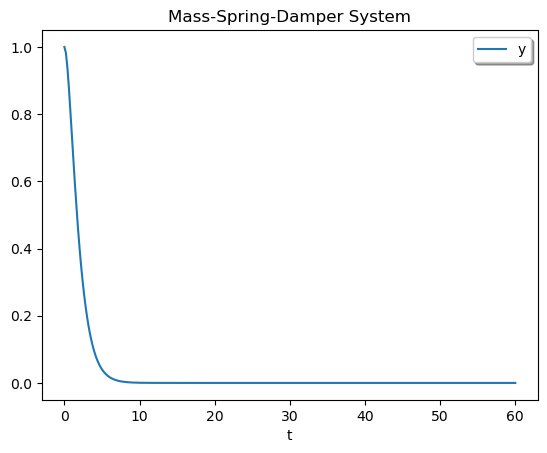

In [212]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def mass_spring_damper(t, y, M, D, K, tau):

    A = np.array([[0,1], [-K/M, -D/M]])
    B = np.array([0, 1/M]).T
    y_dot = A@y + B*tau
    return y_dot

y0 = [1, 0]
# Planning period in sec
T_period = 60
# Integration interval
t_int = [0,T_period]
M = 2
K = 2
D = 4
tau = 0
# Solve ODE
sol = solve_ivp(mass_spring_damper, t_int, y0, args=(M, D, K, tau), dense_output=True)

# Plot

t = np.linspace(t_int[0], t_int[1], 300)
z = sol.sol(t)
plt.plot(t, z[0])
plt.xlabel('t')
plt.legend(['y'], shadow=True)
plt.title('Mass-Spring-Damper System')
plt.show()


# Run full simulation


Time 0:
State: [('GOAL_STATE', 'GOAL_1'), ('CHOICE_STATE', 'NO_MOTION'), ('HUMAN_STATE', 'PROACTIVE')]
Observations: [('FORCE_OBS', 'AROUND_ZERO_FORCE_EVIDENCE'), ('ACTION_SELF_OBS', 'NO_MOTION')]
Beliefs: [('GOAL_STATE', array([0.5, 0.5])), ('CHOICE_STATE', array([1., 0., 0., 0., 0.])), ('HUMAN_STATE', array([0.947, 0.053]))]
Action: [('NULL_STATE_CONTROL', 'NULL'), ('CHOICE_STATE_CONTROL', 'SMALL_MOTION_TO_G1'), ('NULL_STATE_CONTROL_HUMAN', 'NULL')]
Target position:0.0
Current position:0.0
Observed force:10.0

Time 1:
State: [('GOAL_STATE', 'GOAL_1'), ('CHOICE_STATE', 'SMALL_MOTION_TO_G1'), ('HUMAN_STATE', 'PROACTIVE')]
Observations: [('FORCE_OBS', 'TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE'), ('ACTION_SELF_OBS', 'SMALL_MOTION_TO_G1')]
Beliefs: [('GOAL_STATE', array([0.684, 0.316])), ('CHOICE_STATE', array([0., 1., 0., 0., 0.])), ('HUMAN_STATE', array([0.712, 0.288]))]
Action: [('NULL_STATE_CONTROL', 'NULL'), ('CHOICE_STATE_CONTROL', 'SMALL_MOTION_TO_G1'), ('NULL_STATE_CONTROL_HUMAN', 'NUL

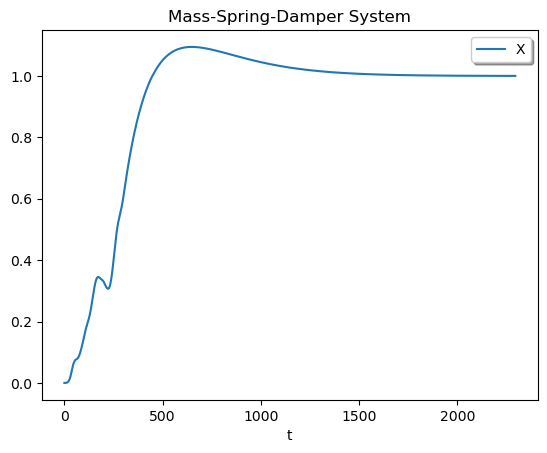

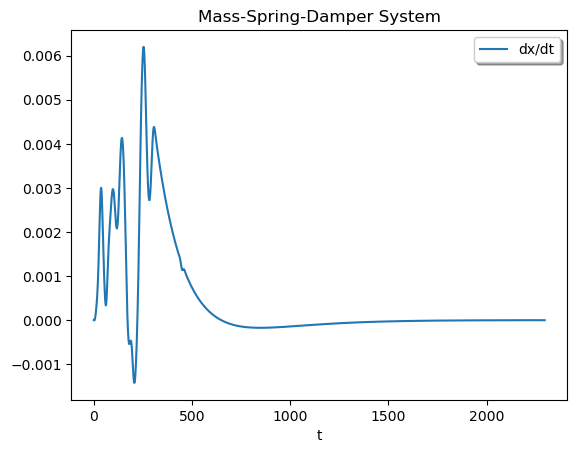

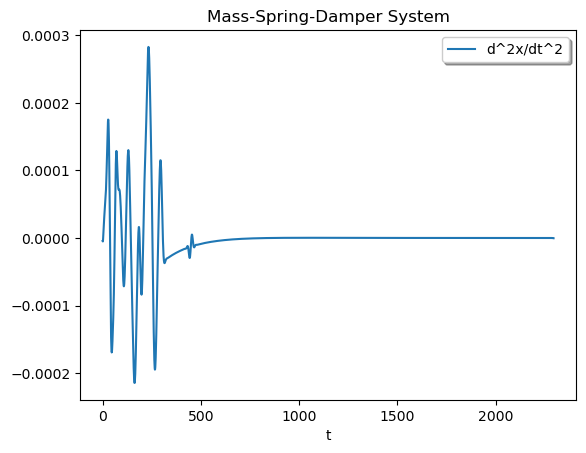

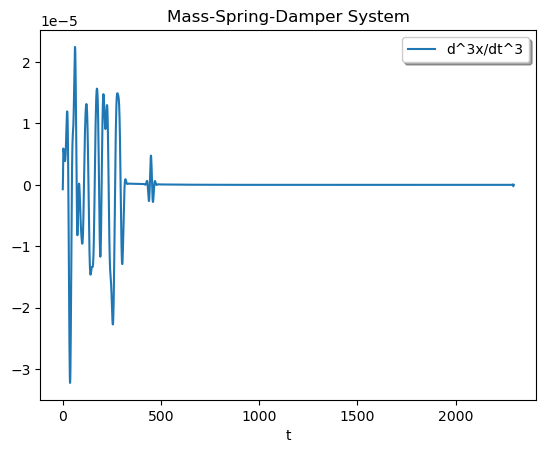

In [213]:
from scipy.signal import savgol_filter
# Generate the trajectory within the control loop
first_output, out_list = None, []

goal_pos = [1, -1]
x_curr = 0.0
dx_curr = 0.0
ddx_curr = 0.0
explorative_dev = 0.1
y_prev = [0,0]
x_traj = [x_curr]
# Planning period in sec
T_period_planning = 0.1
# Control period
T_period_control = 0.01
# Integration interval
t_int = [0,T_period_control]
REACTION_FORCE_FROM_HUMAN = 10
# Trajectory generation with ruckig

from copy import copy
from ruckig import Ruckig, InputParameter, OutputParameter, Result, Trajectory
# Create instances: the Ruckig OTG as well as input and output parameters
num_dof = 1
inp = InputParameter(num_dof)
out = OutputParameter(inp.degrees_of_freedom)
otg = Ruckig(num_dof, T_period_planning)
trajectory = Trajectory(num_dof)


inp.current_position = [x_curr]
inp.current_velocity = [dx_curr]
inp.current_acceleration = [ddx_curr]

inp.target_position = [0.0]
inp.target_velocity = [0.0]
inp.target_acceleration = [0.0]

inp.max_velocity = [1.0]
inp.max_acceleration = [1.0]
inp.max_jerk = [1.0]

x_ref = 0.0
dx_ref = 0.0
ddx_ref = 0.0

x_traj_ref = [x_ref]

for t in range(T):
    
    print(f"\nTime {t}:")
    
    print(f"State: {[(factor_names[f], states_idx_names[f][state[f]]) for f in range(num_factors)]}")
    print(f"Observations: {[(modality_names[g], obs_idx_names[g][observation[g]]) for g in range(num_modalities)]}")
    
    # update agent
    belief_state = agent.infer_states(observation)
    agent.infer_policies()
    action = agent.sample_action()
    
    # Map control states to set-points
    if(int(state[1])==0):
        x_d = x_curr
    elif (int(state[1])==1):
        x_d = explorative_dev*((goal_pos[0] - x_curr)/np.linalg.norm(goal_pos[0] - x_curr)) + x_curr
    elif (int(state[1])==2):
        x_d = explorative_dev*((goal_pos[1] - x_curr)/np.linalg.norm(goal_pos[1] - x_curr)) + x_curr
    elif (int(state[1])==3):
        x_d = goal_pos[0]
    elif (int(state[1])==4):
        x_d = goal_pos[1]
    
        
    # Generate continuous trajectory 
    inp.target_position = [x_d]
    inp.target_velocity = [0.0]
    inp.target_acceleration = [0.0]
    
    # Generate the trajectory within the control loop
    first_output, out_list = None, []
    res = Result.Working
    while res == Result.Working:

        res = otg.update(inp, out)

        x_ref = out.new_position[0]
        dx_ref = out.new_velocity[0]
        ddx_ref = out.new_acceleration[0]
        x_traj_ref= list(np.append(x_traj_ref,x_ref))
        
        y0 = [x_curr - x_ref, dx_curr - dx_ref]  
        
        # Solve ODE
        sol = solve_ivp(mass_spring_damper, t_int, y0, args=(M, D, K, tau))

        x_curr = sol.y[0][-1] + x_ref
        dx_curr = sol.y[1][-1] + dx_ref
        ddx_curr = np.gradient(sol.y[1])[-1] + ddx_ref
        x_traj = list(np.append(x_traj,(sol.y[0][:] + x_ref)))
        
        x_traj = savgol_filter(x_traj, 5, 3)
        out.pass_to_input(inp)

    # update environment
    for f, s in enumerate(state):
        state[f] = utils.sample(B_gp[f][:, s, int(action[f])])

    for g, _ in enumerate(observation):
        observation[g] = utils.sample(A_gp[g][:, state[0], state[1], state[2]])

    # Map force observations into realistic numbers
    if observation[0] == AROUND_ZERO_FORCE_EVIDENCE:
        tau = 0
    elif observation[0] == TOWARDS_GAOL_1_HIGH_FORCE_EVIDENCE:
        tau = REACTION_FORCE_FROM_HUMAN*((goal_pos[0] - x_curr)/np.linalg.norm(goal_pos[0] - x_curr))
    elif observation[0] == TOWARDS_GAOL_2_HIGH_FORCE_EVIDENCE:
        tau = REACTION_FORCE_FROM_HUMAN*((goal_pos[1] - x_curr)/np.linalg.norm(goal_pos[1] - x_curr))
    elif observation[0] == RIGHT_EVIDENCE or observation[0] == WRONG_EVIDENCE:
        tau = 0

    print(f"Beliefs: {[(factor_names[f], belief_state[f].round(3).T) for f in range(num_factors)]}")
    print(f"Action: {[(control_names[a], action_idx_names[a][int(action[a])]) for a in range(num_factors)]}")
    print(f"Target position:{x_d}")
    print(f"Current position:{x_curr}")
    print(f"Observed force:{tau}")


plt.plot(x_traj)
plt.xlabel('t')
plt.legend(['X'], shadow=True)
plt.title('Mass-Spring-Damper System')
plt.show()

# Compute the higher order derivatives of the trajectory

dx_traj = np.gradient(x_traj)

plt.plot(dx_traj)
plt.xlabel('t')
plt.legend(['dx/dt'], shadow=True)
plt.title('Mass-Spring-Damper System')
plt.show()

ddx_traj = np.gradient(dx_traj)

plt.plot(ddx_traj)
plt.xlabel('t')
plt.legend(['d^2x/dt^2'], shadow=True)
plt.title('Mass-Spring-Damper System')
plt.show()

dddx_traj = np.gradient(ddx_traj)

plt.plot(dddx_traj)
plt.xlabel('t')
plt.legend(['d^3x/dt^3'], shadow=True)
plt.title('Mass-Spring-Damper System')
plt.show()